In [72]:
import numpy as np
import scanpy as sc
from scipy.sparse import csr_matrix
import logging
import pandas as pd
import patsy
import matplotlib.pyplot as plt
%matplotlib inline 

In [73]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)
sc.settings.autoshow = True
logging.basicConfig(level=logging.INFO)
logging.getLogger().setLevel(logging.INFO)

scanpy==1.5.0 anndata==0.7.3 umap==0.4.3 numpy==1.18.4 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.1


In [74]:
date = '200527' # e.g. 25th July 2020 = 200725
run = 'run4'    # e.g. JYCVPBMC7 = run7

In [75]:
adata1 = sc.read_10x_mtx(
    '/data/cr_outs/'+ str(date) + '_cr_outs/GEX/lane1_outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True, gex_only = True)                                # write a cache file for faster subsequent reading

... reading from cache file cache/data-cr_outs-200527_cr_outs-GEX-lane1_outs-filtered_feature_bc_matrix-matrix.h5ad


In [76]:
adata2 = sc.read_10x_mtx(
    '/data/cr_outs/'+ str(date) + '_cr_outs/GEX/lane2_outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True, gex_only = True)                                # write a cache file for faster subsequent reading

... reading from cache file cache/data-cr_outs-200527_cr_outs-GEX-lane2_outs-filtered_feature_bc_matrix-matrix.h5ad


In [77]:
adata3 = sc.read_10x_mtx(
    '/data/cr_outs/'+ str(date) + '_cr_outs/GEX/lane3_outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True, gex_only = True)                                # write a cache file for faster subsequent reading

... reading from cache file cache/data-cr_outs-200527_cr_outs-GEX-lane3_outs-filtered_feature_bc_matrix-matrix.h5ad


In [78]:
adata4 = sc.read_10x_mtx(
    '/data/cr_outs/' + str(date) + '_cr_outs/GEX/lane4_outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True, gex_only = True)                                # write a cache file for faster subsequent reading

... reading from cache file cache/data-cr_outs-200527_cr_outs-GEX-lane4_outs-filtered_feature_bc_matrix-matrix.h5ad


In [79]:
print(adata1, adata2, adata3, adata4)

AnnData object with n_obs × n_vars = 20910 × 33538
    var: 'gene_ids', 'feature_types' AnnData object with n_obs × n_vars = 19695 × 33538
    var: 'gene_ids', 'feature_types' AnnData object with n_obs × n_vars = 12689 × 33538
    var: 'gene_ids', 'feature_types' AnnData object with n_obs × n_vars = 15246 × 33538
    var: 'gene_ids', 'feature_types'


In [80]:
adatas = [adata1, adata2, adata3, adata4]

In [81]:
# Save the indivdidual adata files for each 10x lane separaretly
i = 1
for adata in adatas:
    adata.write('/data/count_matrices/covid19/' + str(run) + '/' + str(date) + '_lane' + str(i) + '.h5ad')
    i = i + 1

... storing 'feature_types' as categorical
... storing 'feature_types' as categorical
... storing 'feature_types' as categorical
... storing 'feature_types' as categorical


In [82]:
# Load the indivdidual adata files for each 10x lane separaretly
#i = 1
#for adata in adatas:
#    adata = sc.read('/data/count_matrices/covid19/' + run + '/' + date + '_lane' + str(i) + '.h5ad')
#    i = i + 1

In [83]:
# Make obs for 10x lane 'well' indication
i = 1
for adata in adatas:
    adata.obs['well'] = np.asarray(str(date) + '_lane' + str(i))
    i = i + 1

In [84]:
# Add adata files from adatas in one adata object - while keeping each cellbarcode unique
for adata in adatas:
    adata = adatas[0].concatenate(adatas[1:])

In [85]:
# The previous concatenate has added a column 'batch' that I would like to have removed - as the batch data is already included in 'well'
del adata.obs['batch']
# Remove adata1-6 (i.e. seperate lanes) from memory to save space
del adata1
del adata2
del adata3
del adata4

In [86]:
print('Number of cells per 10x lane')
print(adata.obs['well'].value_counts().sort_index())
print('Total cells x Total genes')
print(adata.shape)

Number of cells per 10x lane
200527_lane1    20910
200527_lane2    19695
200527_lane3    12689
200527_lane4    15246
Name: well, dtype: int64
Total cells x Total genes
(68540, 33538)


In [87]:
# Make obs for experiment run 'run' indication
adata.obs['run'] = np.asarray(str(date) + '_' + str(run))
print(adata.obs)

                              well          run
AAACCTGAGACAAAGG-1-0  200527_lane1  200527_run4
AAACCTGAGACCACGA-1-0  200527_lane1  200527_run4
AAACCTGAGACGCACA-1-0  200527_lane1  200527_run4
AAACCTGAGAGAGCTC-1-0  200527_lane1  200527_run4
AAACCTGAGATCCGAG-1-0  200527_lane1  200527_run4
...                            ...          ...
TTTGTCATCACTTATC-1-3  200527_lane4  200527_run4
TTTGTCATCCATTCTA-1-3  200527_lane4  200527_run4
TTTGTCATCGCGCCAA-1-3  200527_lane4  200527_run4
TTTGTCATCGCTGATA-1-3  200527_lane4  200527_run4
TTTGTCATCTTGAGAC-1-3  200527_lane4  200527_run4

[68540 rows x 2 columns]


In [88]:
#Save the merged lane 1-4 (aka date_run)
adata.write('/data/count_matrices/covid19/' + str(run) + '/' + str(date) + '_' + str(run) + '.h5ad')

... storing 'well' as categorical
... storing 'run' as categorical


In [89]:
# Load the merged lane1-6 Anndata object
#adata = sc.read('/data/count_matrices/covid19/' + str(run) + '/' + str(date) + '_' + str(run) + '.h5ad')

In [90]:
adata.obs.shape

(68540, 2)

In [91]:
####################
# Basic processing #
####################
adata.obs['well'] = adata.obs['well'].astype('category')
adata.obs['run'] = adata.obs['run'].astype('category')
adata.var_names_make_unique()

In [92]:
logging.info(str('Data structure details: ' + str(adata)))
# Extract list of genes
genelist = adata.var_names.tolist()
# Find mitochondrial genes
mito_genes_names = [gene for gene in genelist if gene.startswith('MT-')]
logging.info(str('Mito genes: ' + str(mito_genes_names)))
# Find indices of mitochondrial genes
mito_genes = [genelist.index(gene) for gene in mito_genes_names]
# For each cell compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.ravel(np.sum(adata[:, mito_genes].X, axis=1)) / np.ravel(np.sum(adata.X, axis=1))
# Add the total number of UMIs per cell as observations-annotation to adata 
adata.obs['n_umi'] = np.ravel(adata.X.sum(axis=1))               #axis=1 sum over columns - axis=0 sum over rows

INFO:root:Data structure details: AnnData object with n_obs × n_vars = 68540 × 33538
    obs: 'well', 'run'
    var: 'gene_ids', 'feature_types'
INFO:root:Mito genes: ['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB']


In [93]:
sc.pp.calculate_qc_metrics(adata, inplace = True)

In [94]:
adata.obs['n_genes'] = adata.obs['n_genes_by_counts']

In [95]:
# Remove things added by sc.pp.calculate_qc_metrics that I'm not going to use
del adata.obs['log1p_n_genes_by_counts']
del adata.obs['log1p_total_counts']
del adata.obs['pct_counts_in_top_50_genes']
del adata.obs['pct_counts_in_top_100_genes']
del adata.obs['pct_counts_in_top_200_genes']
del adata.obs['pct_counts_in_top_500_genes']
del adata.obs['total_counts']
del adata.obs['n_genes_by_counts']

In [96]:
# Confirm well, run, percent_mito, n_umi and n_genes are added correctly
adata.obs.head()

well          run  percent_mito   n_umi  n_genes
AAACCTGAGACAAAGG-1-0  200527_lane1  200527_run4      0.066608  4549.0     1722
AAACCTGAGACCACGA-1-0  200527_lane1  200527_run4      0.090194  2162.0      982
AAACCTGAGACGCACA-1-0  200527_lane1  200527_run4      0.056644  1889.0      765
AAACCTGAGAGAGCTC-1-0  200527_lane1  200527_run4      0.060680  2472.0     1004
AAACCTGAGATCCGAG-1-0  200527_lane1  200527_run4      0.073298   573.0      413

In [97]:
# Add new column barcode to adata.obs
adata.obs['barcode'] = adata.obs.index
# Remove the -1 (by 1. selecting only the letters, 2. then the last number, and 3. joining it together again)
adata.obs['barcode'] = adata.obs['barcode'].apply(lambda barcode: '-'.join([barcode.split('-')[0], barcode.split('-')[-1]]))
# Make additional column in adata.obs called 'BARCODE' containing the same info (for merging with output Freemuxlet pipeline)
adata.obs['BARCODE'] = adata.obs['barcode']

### Generate freemuxlet csv file using '/data/notebooks/freemuxlet.ipynb'

In [98]:
# Read csv file with barcode - SNG/DBL/AMB assignments
cell_assignment = pd.read_csv('/data/demux/' + str(date) + '/demux_' + str(run) + '.csv', delimiter=',', dtype='str')

In [99]:
# Merge the cell_assignment csv with adata.obs while matching on cell barcode
adata.obs = adata.obs.merge(cell_assignment, on='BARCODE', how='left').set_axis(adata.obs.index)

In [100]:
del adata.obs['BARCODE']
adata.obs['assignment'] = adata.obs['DROPLET.TYPE']
adata.obs['freemux_cluster'] = adata.obs['SNG.BEST.GUESS']
# After renaming/reassigning same data to new column, remove the old ones: 
del adata.obs['DROPLET.TYPE']
del adata.obs['SNG.BEST.GUESS']
# Confirm that barcode, assignment (SNG/DBL/AMB) and freemux_cluster are added:
adata.obs.head()

well          run  percent_mito   n_umi  \
AAACCTGAGACAAAGG-1-0  200527_lane1  200527_run4      0.066608  4549.0   
AAACCTGAGACCACGA-1-0  200527_lane1  200527_run4      0.090194  2162.0   
AAACCTGAGACGCACA-1-0  200527_lane1  200527_run4      0.056644  1889.0   
AAACCTGAGAGAGCTC-1-0  200527_lane1  200527_run4      0.060680  2472.0   
AAACCTGAGATCCGAG-1-0  200527_lane1  200527_run4      0.073298   573.0   

                      n_genes             barcode assignment freemux_cluster  
AAACCTGAGACAAAGG-1-0     1722  AAACCTGAGACAAAGG-0        DBL              19  
AAACCTGAGACCACGA-1-0      982  AAACCTGAGACCACGA-0        DBL              10  
AAACCTGAGACGCACA-1-0      765  AAACCTGAGACGCACA-0        SNG               5  
AAACCTGAGAGAGCTC-1-0     1004  AAACCTGAGAGAGCTC-0        SNG               2  
AAACCTGAGATCCGAG-1-0      413  AAACCTGAGATCCGAG-0        SNG               2

In [101]:
# Make everything the correct category
adata.obs['barcode'] = adata.obs['barcode'].astype('category')
adata.obs['assignment'] = adata.obs['assignment'].astype('category')
adata.obs['freemux_cluster'] = adata.obs['freemux_cluster'].astype('int32')
adata.obs.head()

well          run  percent_mito   n_umi  \
AAACCTGAGACAAAGG-1-0  200527_lane1  200527_run4      0.066608  4549.0   
AAACCTGAGACCACGA-1-0  200527_lane1  200527_run4      0.090194  2162.0   
AAACCTGAGACGCACA-1-0  200527_lane1  200527_run4      0.056644  1889.0   
AAACCTGAGAGAGCTC-1-0  200527_lane1  200527_run4      0.060680  2472.0   
AAACCTGAGATCCGAG-1-0  200527_lane1  200527_run4      0.073298   573.0   

                      n_genes             barcode assignment  freemux_cluster  
AAACCTGAGACAAAGG-1-0     1722  AAACCTGAGACAAAGG-0        DBL               19  
AAACCTGAGACCACGA-1-0      982  AAACCTGAGACCACGA-0        DBL               10  
AAACCTGAGACGCACA-1-0      765  AAACCTGAGACGCACA-0        SNG                5  
AAACCTGAGAGAGCTC-1-0     1004  AAACCTGAGAGAGCTC-0        SNG                2  
AAACCTGAGATCCGAG-1-0      413  AAACCTGAGATCCGAG-0        SNG                2

## Run Scrublet for identification doublets (especially from same donor)

**Run for each lane separately, as that's the only cells that can form doublets**

In [102]:
# For scrublet doublet removal
import scrublet as scr
import scipy.io
import os
import math 

In [103]:
# Total run 1
adata
# Only lane 1-4 separately
lane1 = adata[adata.obs['well'] == str(date) + '_lane1']
lane2 = adata[adata.obs['well'] == str(date) + '_lane2']
lane3 = adata[adata.obs['well'] == str(date) + '_lane3']
lane4 = adata[adata.obs['well'] == str(date) + '_lane4']

In [104]:
# Expected doublet rate: calculate 8.4% for every 10,000 cells (based on 10x expected multiplet rate for v2 + 10% extra as in practice you'll always have more than 
# just the theoretical expected rate) --> So divide the number of cells in each lane by (10,000/8.4) for the expected_doublet_rate
dbl_lane1 = (len(lane1)/(10000/8.4))/100
dbl_lane2 = (len(lane2)/(10000/8.4))/100
dbl_lane3 = (len(lane3)/(10000/8.4))/100
dbl_lane4 = (len(lane4)/(10000/8.4))/100

In [105]:
# Only the expected_doublet_rate is manually set, otherwise I use standard parameters. The precise number of the expected_doublet_rate is not that important.
# If the doublet threshold doesn't split the bimodal distribution/would be completely off, then set this manually using: scrub.call_doublets(threshold= ...) -->
# Check the scrub.plot_histogram() for the threshold that fits the 'Observed transcriptomes' data best.

In [106]:
# ONLY LANE1: 
scrub1 = scr.Scrublet(lane1.X, expected_doublet_rate=dbl_lane1, sim_doublet_ratio = 2, n_neighbors = round(0.5*math.sqrt(len(lane1))))
# n_neighbors: Number of neighbors used to construct the KNN classifier of observed transcriptomes and simulated doublets. 
# The default value of round(0.5*sqrt(n_cells)) generally works well.

In [107]:
doublet_scores, predicted_doublets = scrub1.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.24
Detected doublet rate = 23.7%
Estimated detectable doublet fraction = 72.2%
Overall doublet rate:
	Expected   = 17.6%
	Estimated  = 32.8%
Elapsed time: 25.9 seconds


(<Figure size 640x240 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f33a5c210>,
       dtype=object))

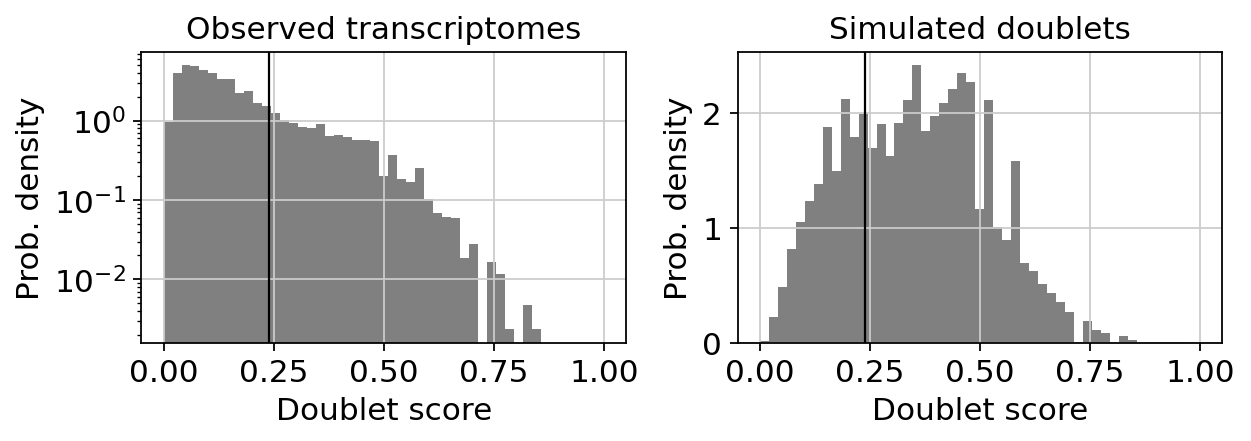

In [108]:
# Check whether doublet threshold is set ok (should be bimodal distribution ideally)
scrub1.plot_histogram()

In [109]:
# If manually adjusting:
scrub1.call_doublets(threshold= 0.3)

Detected doublet rate = 16.5%
Estimated detectable doublet fraction = 60.9%
Overall doublet rate:
	Expected   = 17.6%
	Estimated  = 27.1%


array([ True,  True, False, ...,  True, False, False])

(<Figure size 640x240 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f4d187210>,
       dtype=object))

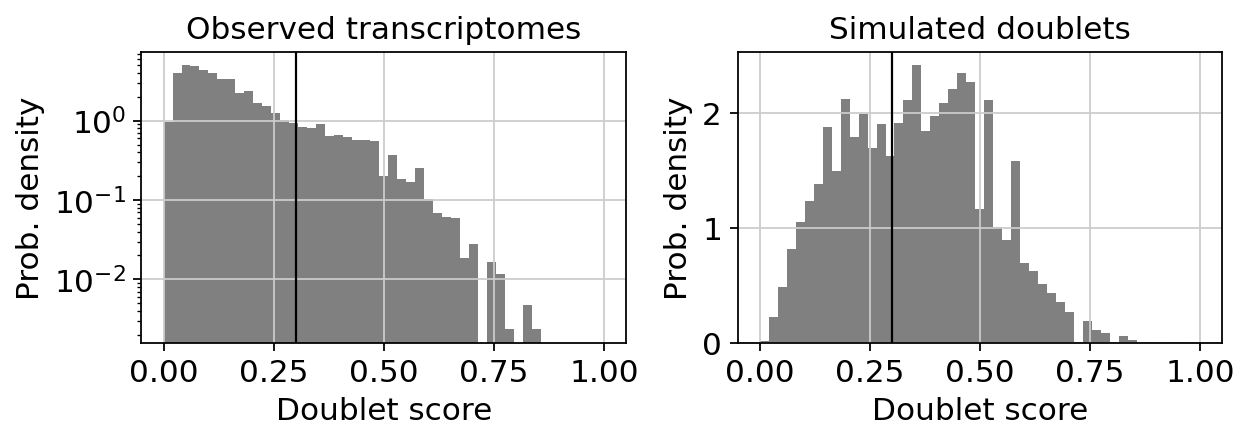

In [110]:
# Check whether doublet threshold is set ok (should be bimodal distribution ideally)
scrub1.plot_histogram()

In [111]:
print('Running UMAP...')
scrub1.set_embedding('UMAP', scr.get_umap(scrub1.manifold_obs_, 10, min_dist=0.3))
print('Done.')

Running UMAP...
Done.


/home/ssm-user/anaconda3/envs/r_env/lib/python3.7/site-packages/scrublet/scrublet.py:550: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  cmap=cmap_use, vmin=vmin, vmax=vmax)
/home/ssm-user/anaconda3/envs/r_env/lib/python3.7/site-packages/scrublet/scrublet.py:562: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax.scatter(x[o], y[o], s=marker_size, edgecolors='', c=called_doubs[o], cmap=custom_cmap([[.7,.7,.7], [0,0,0]]))


(<Figure size 640x320 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f452475d0>,
       dtype=object))

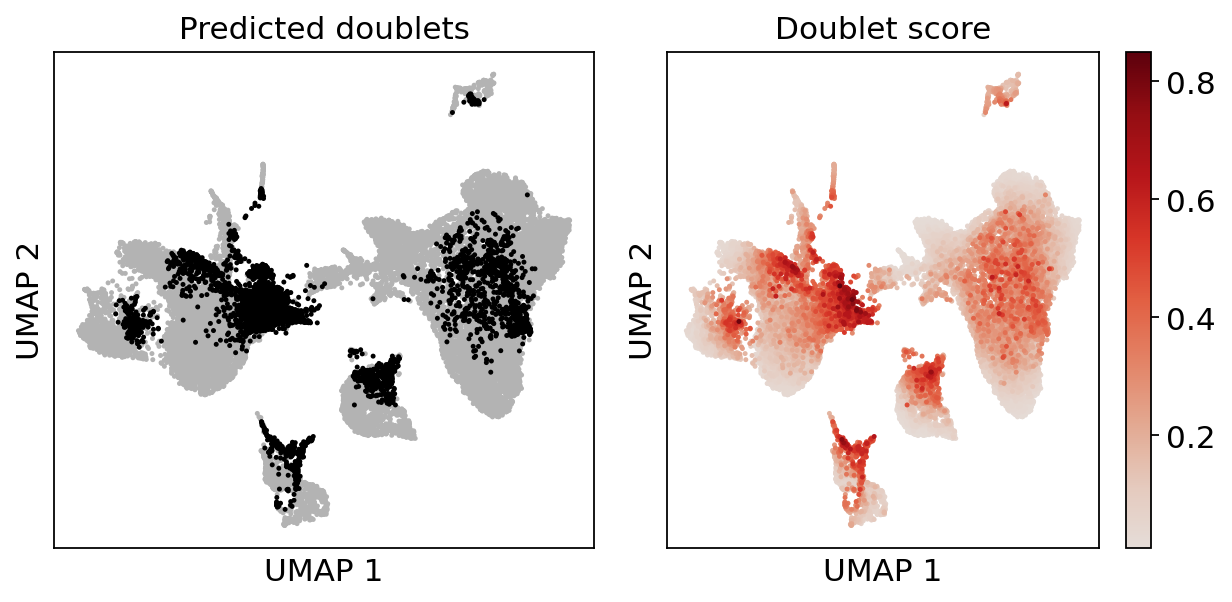

In [112]:
#Plot doublet predictions on 2-D embedding --> should co-localize in distinct states.
scrub1.plot_embedding('UMAP', order_points=True)

In [113]:
# ONLY LANE2
scrub2 = scr.Scrublet(lane2.X, expected_doublet_rate=dbl_lane2, sim_doublet_ratio = 2, n_neighbors = round(0.5*math.sqrt(len(lane2))))

In [114]:
doublet_scores, predicted_doublets = scrub2.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.30
Detected doublet rate = 13.6%
Estimated detectable doublet fraction = 56.4%
Overall doublet rate:
	Expected   = 16.5%
	Estimated  = 24.1%
Elapsed time: 24.6 seconds


(<Figure size 640x240 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f47666590>,
       dtype=object))

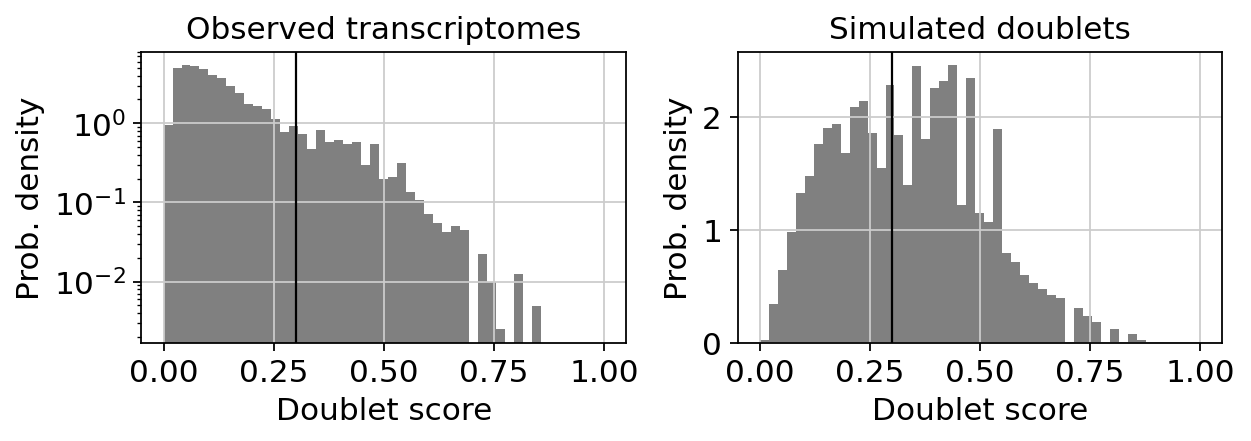

In [115]:
# Check whether doublet threshold is set ok (should be bimodal distribution ideally)
scrub2.plot_histogram()

In [122]:
# If manually adjusting:
scrub2.call_doublets(threshold= 0.33)

Detected doublet rate = 11.7%
Estimated detectable doublet fraction = 51.4%
Overall doublet rate:
	Expected   = 16.5%
	Estimated  = 22.7%


array([False,  True, False, ...,  True, False, False])

(<Figure size 640x240 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e9dd17c10>,
       dtype=object))

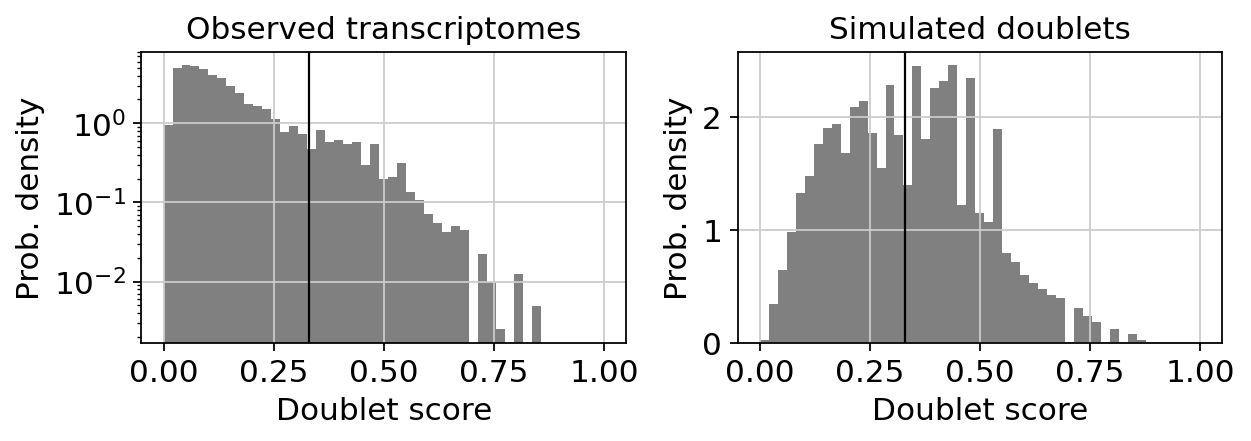

In [123]:
# Check whether doublet threshold is set ok (should be bimodal distribution ideally)
scrub2.plot_histogram()

In [124]:
print('Running UMAP...')
scrub2.set_embedding('UMAP', scr.get_umap(scrub2.manifold_obs_, 10, min_dist=0.3))
print('Done.')

Running UMAP...
Done.


/home/ssm-user/anaconda3/envs/r_env/lib/python3.7/site-packages/scrublet/scrublet.py:550: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  cmap=cmap_use, vmin=vmin, vmax=vmax)
/home/ssm-user/anaconda3/envs/r_env/lib/python3.7/site-packages/scrublet/scrublet.py:562: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax.scatter(x[o], y[o], s=marker_size, edgecolors='', c=called_doubs[o], cmap=custom_cmap([[.7,.7,.7], [0,0,0]]))


(<Figure size 640x320 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e9da8bfd0>,
       dtype=object))

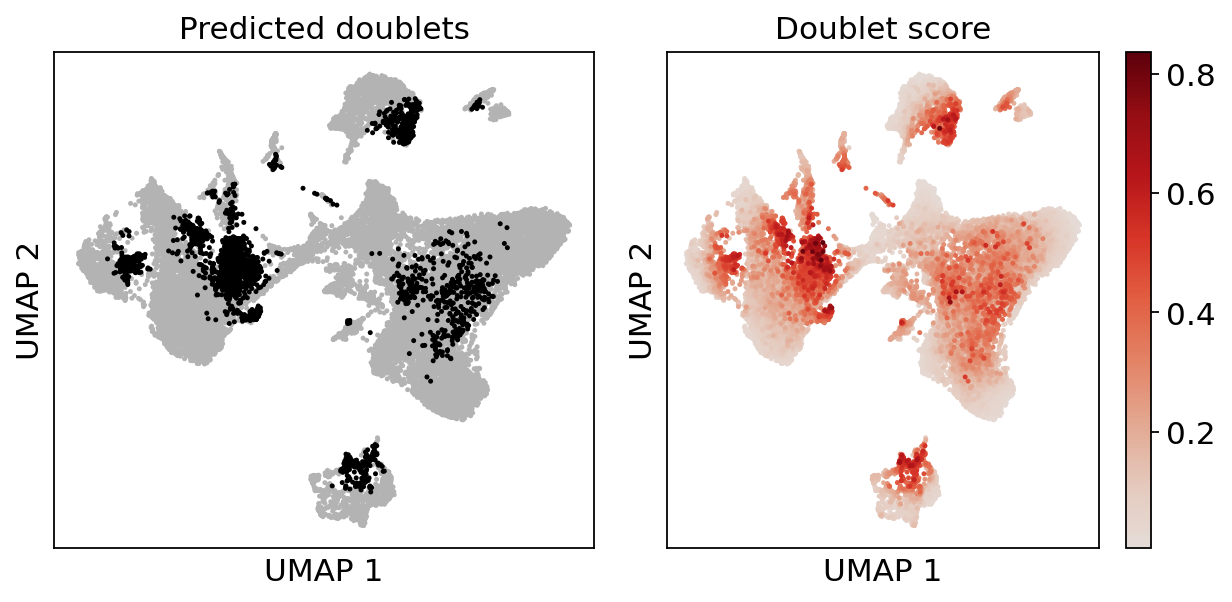

In [125]:
#Plot doublet predictions on 2-D embedding --> should co-localize in distinct states.
scrub2.plot_embedding('UMAP', order_points=True)

In [126]:
# ONLY LANE3
scrub3 = scr.Scrublet(lane3.X, expected_doublet_rate=dbl_lane3, sim_doublet_ratio = 2, n_neighbors = round(0.5*math.sqrt(len(lane3))))

In [127]:
doublet_scores, predicted_doublets = scrub3.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.28
Detected doublet rate = 6.9%
Estimated detectable doublet fraction = 43.2%
Overall doublet rate:
	Expected   = 10.7%
	Estimated  = 16.0%
Elapsed time: 14.0 seconds


(<Figure size 640x240 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e9d34d090>,
       dtype=object))

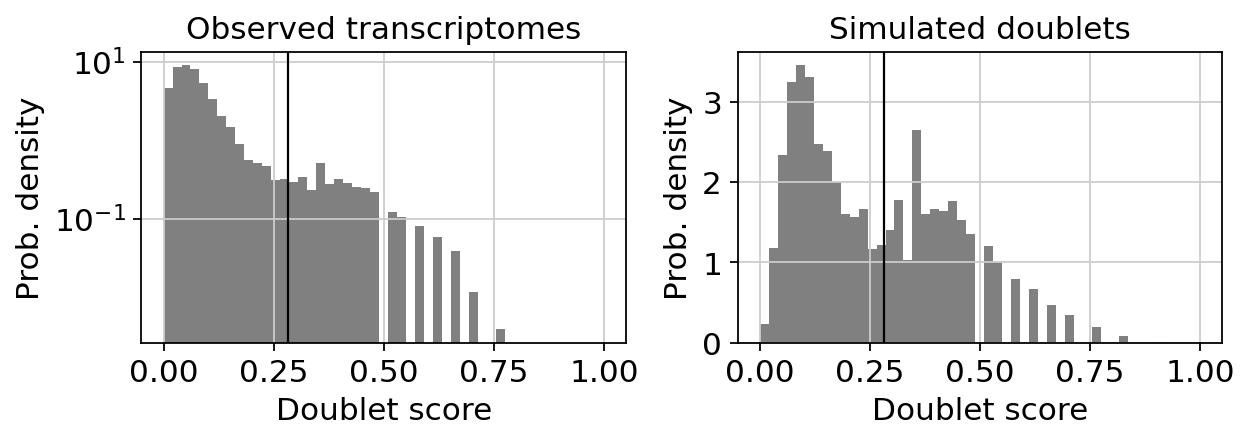

In [128]:
# Check whether doublet threshold is set ok (should be bimodal distribution ideally)
scrub3.plot_histogram()

In [129]:
print('Running UMAP...')
scrub3.set_embedding('UMAP', scr.get_umap(scrub3.manifold_obs_, 10, min_dist=0.3))
print('Done.')

Running UMAP...
Done.


/home/ssm-user/anaconda3/envs/r_env/lib/python3.7/site-packages/scrublet/scrublet.py:550: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  cmap=cmap_use, vmin=vmin, vmax=vmax)
/home/ssm-user/anaconda3/envs/r_env/lib/python3.7/site-packages/scrublet/scrublet.py:562: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax.scatter(x[o], y[o], s=marker_size, edgecolors='', c=called_doubs[o], cmap=custom_cmap([[.7,.7,.7], [0,0,0]]))


(<Figure size 640x320 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e9d2e8ad0>,
       dtype=object))

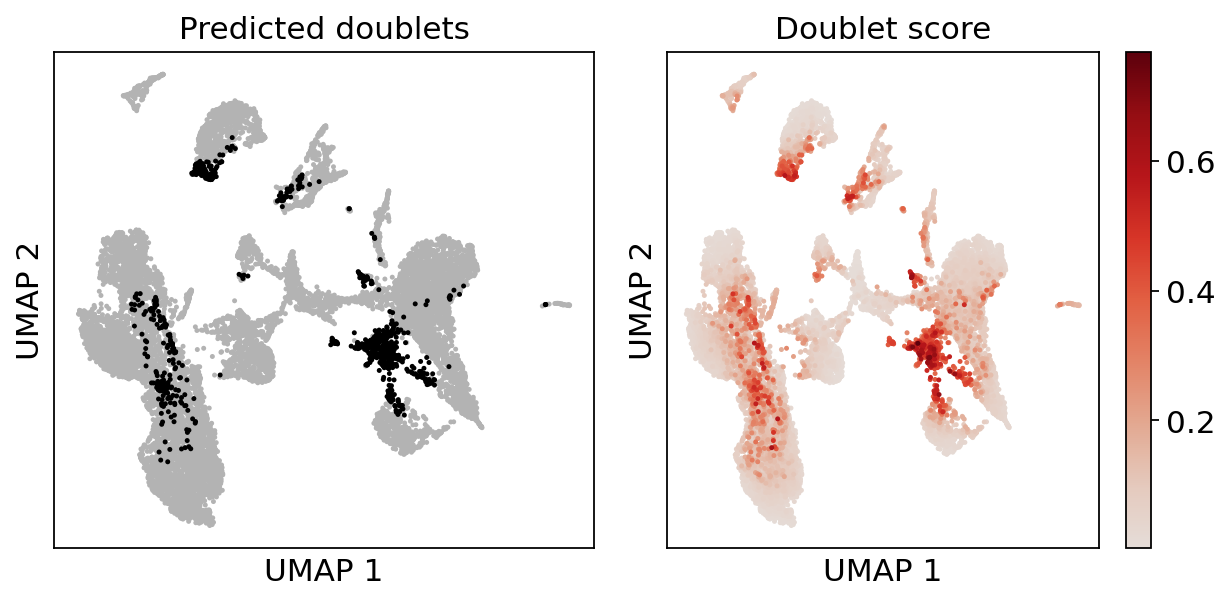

In [130]:
#Plot doublet predictions on 2-D embedding --> should co-localize in distinct states.
scrub3.plot_embedding('UMAP', order_points=True)

In [131]:
# ONLY LANE4
scrub4 = scr.Scrublet(lane4.X, expected_doublet_rate=dbl_lane4, sim_doublet_ratio = 2, n_neighbors = round(0.5*math.sqrt(len(lane4))))

In [132]:
doublet_scores, predicted_doublets = scrub4.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.28
Detected doublet rate = 8.5%
Estimated detectable doublet fraction = 48.9%
Overall doublet rate:
	Expected   = 12.8%
	Estimated  = 17.4%
Elapsed time: 17.7 seconds


(<Figure size 640x240 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e9d377350>,
       dtype=object))

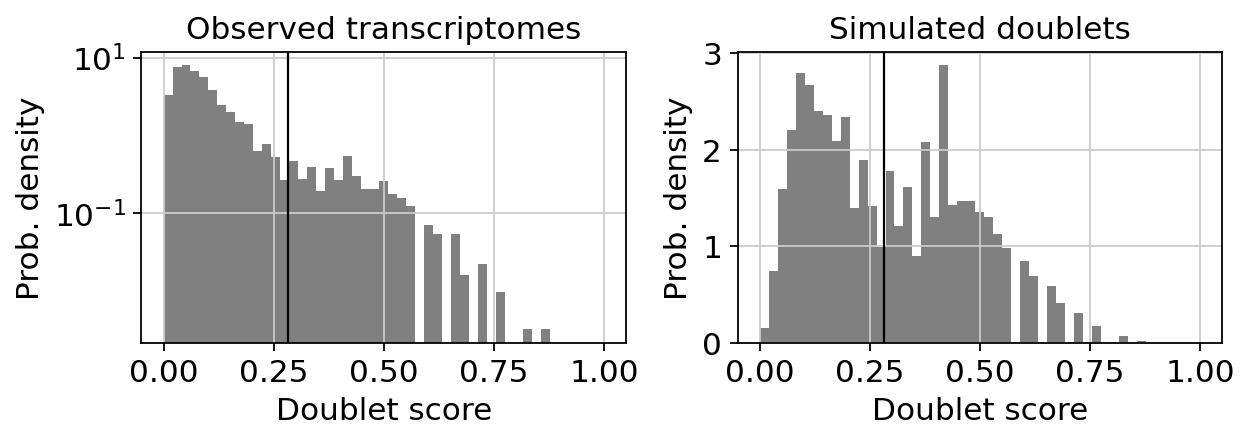

In [133]:
# Check whether doublet threshold is set ok (should be bimodal distribution ideally)
scrub4.plot_histogram()

In [134]:
print('Running UMAP...')
scrub4.set_embedding('UMAP', scr.get_umap(scrub4.manifold_obs_, 10, min_dist=0.3))
print('Done.')

Running UMAP...
Done.


/home/ssm-user/anaconda3/envs/r_env/lib/python3.7/site-packages/scrublet/scrublet.py:550: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  cmap=cmap_use, vmin=vmin, vmax=vmax)
/home/ssm-user/anaconda3/envs/r_env/lib/python3.7/site-packages/scrublet/scrublet.py:562: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax.scatter(x[o], y[o], s=marker_size, edgecolors='', c=called_doubs[o], cmap=custom_cmap([[.7,.7,.7], [0,0,0]]))


(<Figure size 640x320 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e9d8ba1d0>,
       dtype=object))

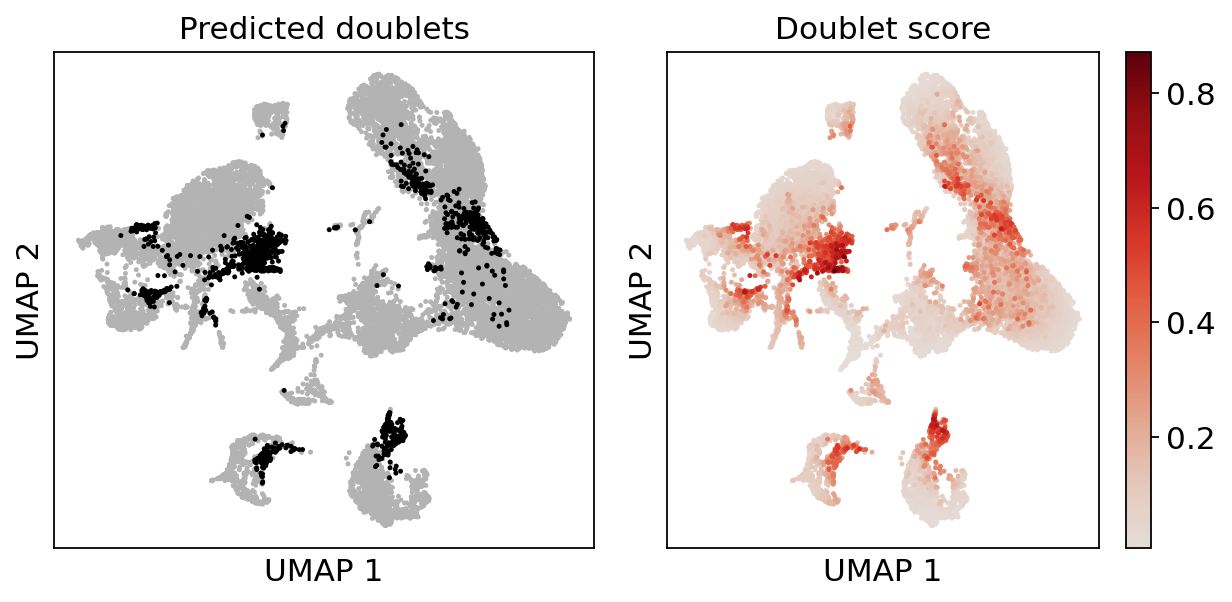

In [135]:
#Plot doublet predictions on 2-D embedding --> should co-localize in distinct states.
scrub4.plot_embedding('UMAP', order_points=True)

In [136]:
print('Number of cells after QC - input for Scrublet:')
print(len(scrub1.predicted_doublets_))
print(len(scrub2.predicted_doublets_))
print(len(scrub3.predicted_doublets_))
print(len(scrub4.predicted_doublets_))

Number of cells after QC - input for Scrublet:
20910
19695
12689
15246


In [137]:
# Lane1
scrub1_doublets = scrub1.predicted_doublets_
scrub1_doublets_true = scrub1_doublets[scrub1_doublets == True]
scrub1_doublets_false = scrub1_doublets[scrub1_doublets == False]
print("Number of cells after QC:")
print(len(scrub1.predicted_doublets_))
print("Number of doublets called by Scrublet:")
print(len(scrub1_doublets_true))
print("Number of singlets called by Scrublet:")
print(len(scrub1_doublets_false))
print("Doublet rate as calculated by Scrublet:")
len(scrub1_doublets_true)/(len(scrub1_doublets_true) + len(scrub1_doublets_false))*100

Number of cells after QC:
20910
Number of doublets called by Scrublet:
3449
Number of singlets called by Scrublet:
17461
Doublet rate as calculated by Scrublet:


16.49450023912004

In [138]:
# Lane2
scrub2_doublets = scrub2.predicted_doublets_
scrub2_doublets_true = scrub2_doublets[scrub2_doublets == True]
scrub2_doublets_false = scrub2_doublets[scrub2_doublets == False]
print("Number of cells after QC:")
print(len(scrub2.predicted_doublets_))
print("Number of doublets called by Scrublet:")
print(len(scrub2_doublets_true))
print("Number of singlets called by Scrublet:")
print(len(scrub2_doublets_false))
print("Doublet rate as calculated by Scrublet:")
len(scrub2_doublets_true)/(len(scrub2_doublets_true) + len(scrub2_doublets_false))*100

Number of cells after QC:
19695
Number of doublets called by Scrublet:
2298
Number of singlets called by Scrublet:
17397
Doublet rate as calculated by Scrublet:


11.667936024371668

In [139]:
# Lane3
scrub3_doublets = scrub3.predicted_doublets_
scrub3_doublets_true = scrub3_doublets[scrub3_doublets == True]
scrub3_doublets_false = scrub3_doublets[scrub3_doublets == False]
print("Number of cells after QC:")
print(len(scrub3.predicted_doublets_))
print("Number of doublets called by Scrublet:")
print(len(scrub3_doublets_true))
print("Number of singlets called by Scrublet:")
print(len(scrub3_doublets_false))
print("Doublet rate as calculated by Scrublet:")
len(scrub3_doublets_true)/(len(scrub3_doublets_true) + len(scrub3_doublets_false))*100

Number of cells after QC:
12689
Number of doublets called by Scrublet:
875
Number of singlets called by Scrublet:
11814
Doublet rate as calculated by Scrublet:


6.8957364646544255

In [140]:
# Lane4
scrub4_doublets = scrub4.predicted_doublets_
scrub4_doublets_true = scrub4_doublets[scrub4_doublets == True]
scrub4_doublets_false = scrub4_doublets[scrub4_doublets == False]
print("Number of cells after QC:")
print(len(scrub4.predicted_doublets_))
print("Number of doublets called by Scrublet:")
print(len(scrub4_doublets_true))
print("Number of singlets called by Scrublet:")
print(len(scrub4_doublets_false))
print("Doublet rate as calculated by Scrublet:")
len(scrub4_doublets_true)/(len(scrub4_doublets_true) + len(scrub4_doublets_false))*100

Number of cells after QC:
15246
Number of doublets called by Scrublet:
1301
Number of singlets called by Scrublet:
13945
Doublet rate as calculated by Scrublet:


8.53338580611308

In [141]:
scrubs = [scrub1, scrub2, scrub3, scrub4]

In [142]:
# Determine which cells are being assigned as doublet (DBL) or singlet (SNG) and rename as such
i = 1
for scrub in scrubs:
    scrub.predicted_doublets_ = np.where(scrub.predicted_doublets_ == True, 'DBL', scrub.predicted_doublets_) 
    scrub.predicted_doublets_ = np.where(scrub.predicted_doublets_ == 'False', 'SNG', scrub.predicted_doublets_)
    i = i + 1

In [143]:
# Make dataframe with cell barcode as index and scrublet assignment as column
scrub1_output = pd.DataFrame(data=scrub1.predicted_doublets_,    # values
                             index=lane1.obs_names,    # index names
                             columns= ['scrublet'])    # column name

scrub2_output = pd.DataFrame(data=scrub2.predicted_doublets_,    # values
                             index=lane2.obs_names,    # index names
                             columns= ['scrublet'])    # column name

scrub3_output = pd.DataFrame(data=scrub3.predicted_doublets_,    # values
                             index=lane3.obs_names,    # index names
                             columns= ['scrublet'])    # column name

scrub4_output = pd.DataFrame(data=scrub4.predicted_doublets_,    # values
                             index=lane4.obs_names,    # index names
                             columns= ['scrublet'])    # column name

In [144]:
# Concatenate the 4 dataframes for complete run 4
scrub_outputs_run1 = [scrub1_output, scrub2_output, scrub3_output, scrub4_output]
scrub_run1 = pd.concat(scrub_outputs_run1)

In [145]:
print(scrub_run1.shape)
print(adata.shape)

(68540, 1)
(68540, 33538)


In [146]:
# Merge scrublet output with run 1 QCed dataframe (filters, but not yet Freemuxlet) while matching on cell barcode
adata.obs = adata.obs.merge(scrub_run1, left_index= True, right_index = True, how='left').set_axis(adata.obs.index)

In [147]:
freemux_scrublet = pd.crosstab(index=adata.obs['assignment'], 
                           columns=adata.obs['scrublet'])
print(freemux_scrublet)

scrublet     DBL    SNG
assignment             
AMB            0    268
DBL         5894   8711
SNG         2029  51638


In [148]:
# Run4 QC filtered (but not yet DBL removal Freemux/Scrublet)
adata.write('/data/count_matrices/covid19/' + str(run) + '/' + str(date) + '_' + str(run) + '_freemux_scrublet.h5ad')

... storing 'scrublet' as categorical


### Doublet/Single assignment according to Freemuxlet vs Scrublet

In [149]:
# How many SNG/AMB/DBL?
adata_subset_SNG = adata[adata.obs['assignment'].isin(['SNG'])]
adata_subset_AMB = adata[adata.obs['assignment'].isin(['AMB'])]
adata_subset_DBL = adata[adata.obs['assignment'].isin(['DBL'])]
print('Number of singlets is', adata_subset_SNG.n_obs)
print('Number of ambiguous is', adata_subset_AMB.n_obs)
print('Number of doublets is', adata_subset_DBL.n_obs)

Number of singlets is 53667
Number of ambiguous is 268
Number of doublets is 14605


In [150]:
# How many SNG/DBL according to Scrublet?
adata_subset_SNG2 = adata[adata.obs['scrublet'].isin(['SNG'])]
adata_subset_DBL2 = adata[adata.obs['scrublet'].isin(['DBL'])]
print('Number of singlets is', adata_subset_SNG2.n_obs)
print('Number of doublets is', adata_subset_DBL2.n_obs)

Number of singlets is 60617
Number of doublets is 7923


In [151]:
# Keep only the singlets - first filtered for Scrublet, after filtered for Freemuxlet
adata = adata_subset_SNG2
print(adata.shape)
adata_subset_SNG = adata[adata.obs['assignment'].isin(['SNG'])]
adata = adata_subset_SNG
print(adata.shape)

(60617, 33538)
(51638, 33538)


### QC filtering

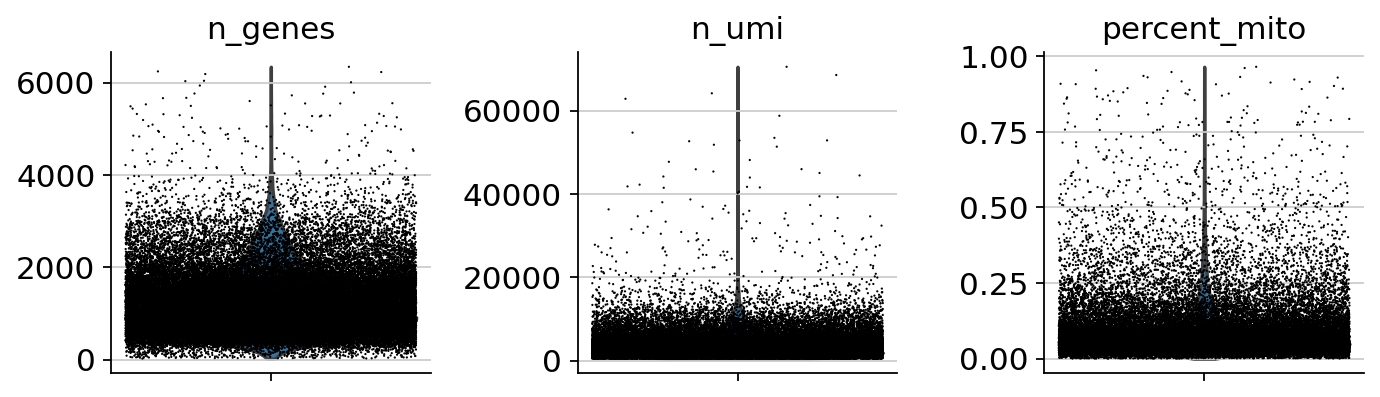

In [152]:
# Before filtering for QC parameters
sc.pl.violin(adata, ['n_genes', 'n_umi', 'percent_mito'],
             jitter=0.4, multi_panel=True)

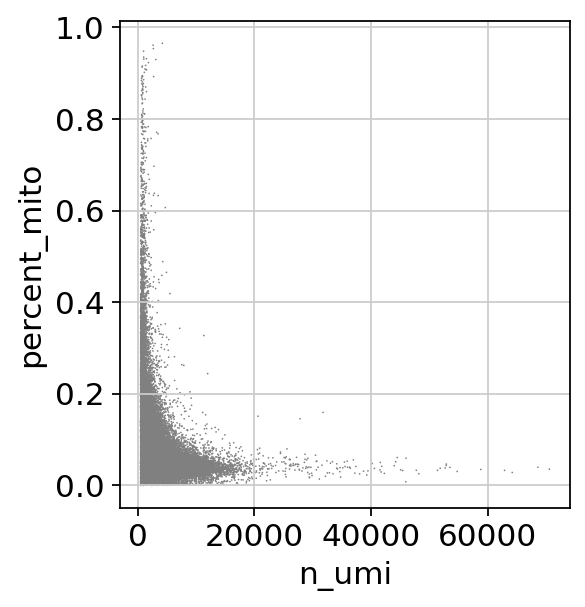

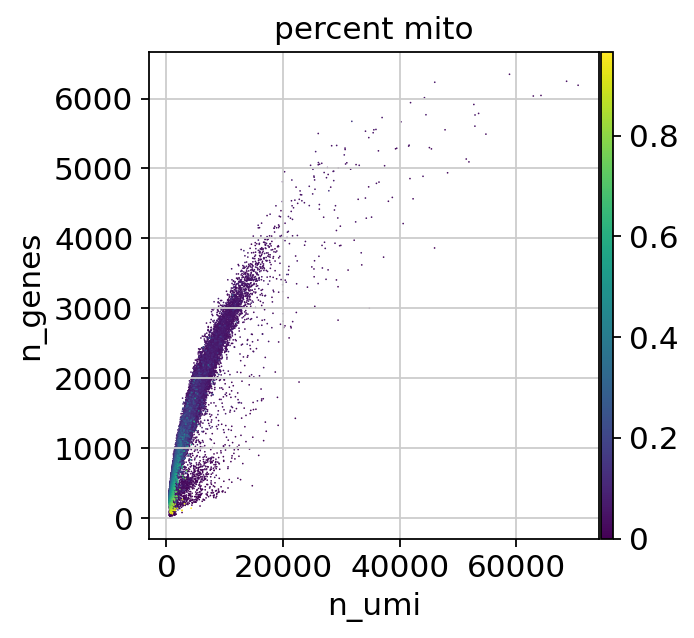

In [153]:
# Before filtering cells with <200 genes/cell and >=15% mito reads
sc.pl.scatter(adata, x='n_umi', y='percent_mito')
sc.pl.scatter(adata, x='n_umi', y='n_genes', color = 'percent_mito')

In [154]:
# Filter out cells with <200 genes/cell and genes that are not expressed in at least 3 cells
print(adata.shape)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
print(adata.shape)

(51638, 33538)
filtered out 392 cells that have less than 200 genes expressed


Trying to set attribute `.obs` of view, copying.


filtered out 12821 genes that are detected in less than 3 cells
(51246, 20717)


In [155]:
# Confirm that filter on n_genes worked correctly
adata.obs['n_genes'].describe()

count    51246.000000
mean      1267.987258
std        664.457820
min        200.000000
25%        791.000000
50%       1151.000000
75%       1607.000000
max       6347.000000
Name: n_genes, dtype: float64

In [156]:
print("Filter out cells with >=15% mito reads")
adata = adata[adata.obs.percent_mito < 0.15, :]
print(adata.shape)

Filter out cells with >=15% mito reads
(45877, 20717)


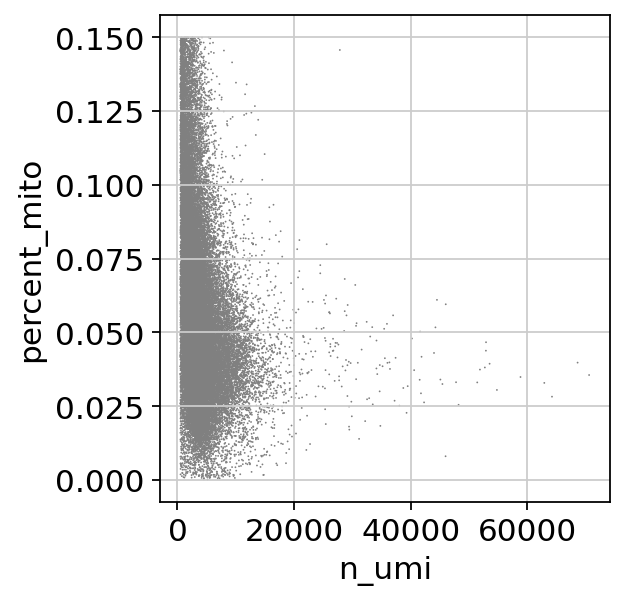

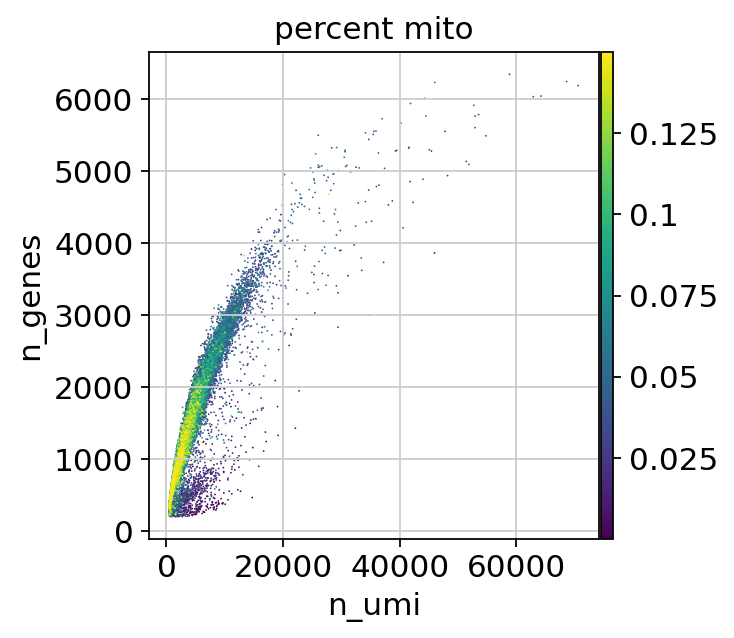

In [157]:
# After filtering cells with <200 genes/cell and >=15% mito reads
sc.pl.scatter(adata, x='n_umi', y='percent_mito')
sc.pl.scatter(adata, x='n_umi', y='n_genes', color = 'percent_mito')

### Define the best cut-off to remove erythrocytes

In [158]:
logging.info(str('Data structure details: ' + str(adata)))
logging.info('Removing Erythrocytes.')
mat = csr_matrix(adata.X)                                            #compressed sparse row matrix of adata.X (cell by gene matrix)
mat = mat[:, adata.var_names.isin(['HBB'])].todense()                #select all cells, but just extract the HBB expression

INFO:root:Data structure details: View of AnnData object with n_obs × n_vars = 45877 × 20717
    obs: 'well', 'run', 'percent_mito', 'n_umi', 'n_genes', 'barcode', 'assignment', 'freemux_cluster', 'scrublet'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
INFO:root:Removing Erythrocytes.


In [159]:
#Remove all cells that have HBB> 10 (indicative of RBCs)
adata3 = adata[np.ravel(mat <= 10)]                  # This seems the better cut-off (tested mat <= 1 before but that took out too many other cell types -
                                                     # probably RBC background mRNA in the 'soup')

In [160]:
HBA1_expr = adata.X[:, adata.var_names.str.match('HBA1')].todense()
HBA2_expr = adata.X[:, adata.var_names.str.match('HBA2')].todense()
HBB_expr = adata.X[:, adata.var_names.str.match('HBB')].todense()
HBD_expr = adata.X[:, adata.var_names.str.match('HBD')].todense()

HBA1_expr3 = adata3.X[:, adata3.var_names.str.match('HBA1')].todense()
HBA2_expr3 = adata3.X[:, adata3.var_names.str.match('HBA2')].todense()
HBB_expr3 = adata3.X[:, adata3.var_names.str.match('HBB')].todense()
HBD_expr3 = adata3.X[:, adata3.var_names.str.match('HBD')].todense()

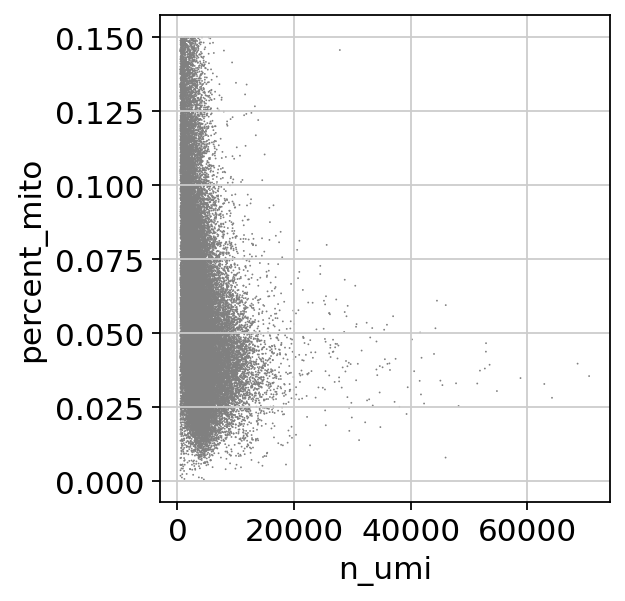

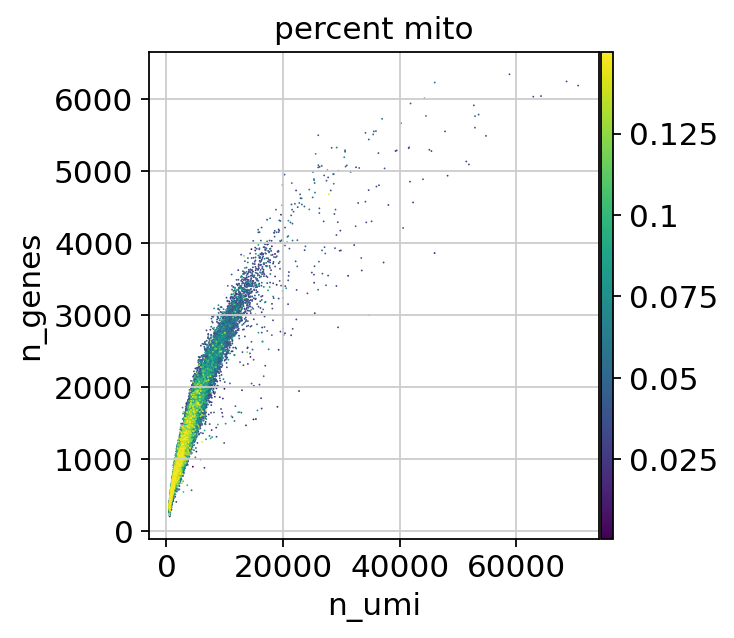

In [161]:
# After filtering cells with <200 genes/cell and >=15% mito reads and RBC cut off (HBB > 10)
sc.pl.scatter(adata3, x='n_umi', y='percent_mito')
sc.pl.scatter(adata3, x='n_umi', y='n_genes', color = 'percent_mito')

In [162]:
print(adata.shape)
print(adata3.shape)

(45877, 20717)
(44295, 20717)


In [163]:
# Select HBB>10 as the RBC cut-off
adata = adata3
print(adata.shape)

(44295, 20717)


In [164]:
#Save the merged lane 1-4 including QC filters applied and Scrublet + Freemuxlet filtered
adata.write('/data/count_matrices/covid19/' + str(run) + '/' + str(date) + '_' + str(run) + '_final2.h5ad')